In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torchvision
import torch.nn as nn
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

from sklearn.metrics import accuracy_score ,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
transform = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [5]:
# Load and split dataset

image_dir = "/content/drive/MyDrive/cell_images"
full_dataset = datasets.ImageFolder(image_dir)

train_indices, test_indices = train_test_split(list(range(len(full_dataset))), test_size=0.2, random_state=42)

train_subset = torch.utils.data.Subset(full_dataset, train_indices)
test_subset = torch.utils.data.Subset(full_dataset, test_indices)

train_subset.dataset.transform = transform
test_subset.dataset.transform = transform

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_subset, batch_size=32, shuffle=False)

print("Number of images in train set:", len(train_subset))
print("Number of images in test set:", len(test_subset))

Number of images in train set: 22370
Number of images in test set: 5593


In [6]:
model = models.resnet50(pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001 , momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 86.4MB/s]


Epoch 0 : 0.4369769084772893
Epoch 1 : 0.23937692179211548
Finished Training
Test accuracy: 91.04237439656714


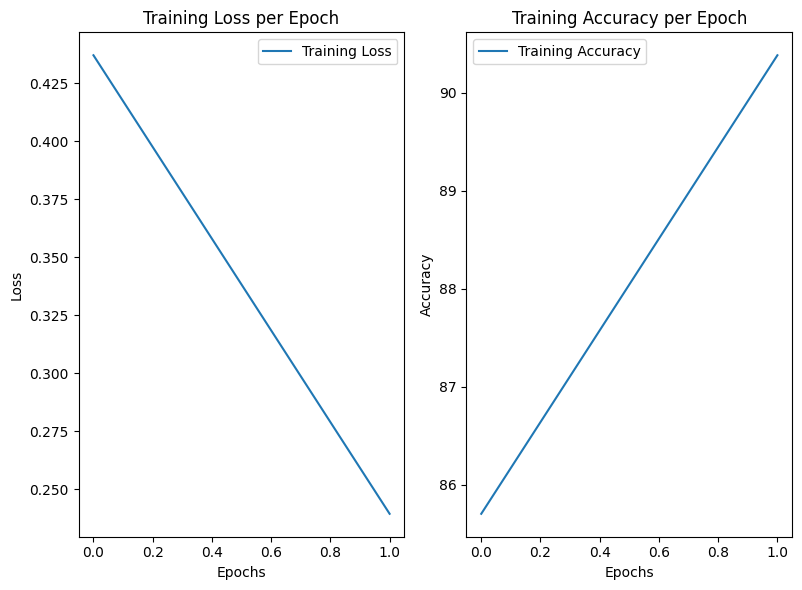

In [6]:
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    total_count = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # calculate training accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

        # print statistics
        running_loss += loss.item()
        total_count += 1

    train_losses.append(running_loss / total_count)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    # print('Training accuracy: %d %%' % train_accuracy)

    print("Epoch", epoch, ":", running_loss / total_count)
    # print('Accuracy of the network on the 10000 test images: %d %%' % test_accuracy)

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print("Test accuracy:", test_accuracy)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
model.eval()
all_preds = []
all_labels = []
count = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        count += 1


class_names = full_dataset.classes
print(class_names)
print(all_labels)
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

# Classification report and confusion matrix
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# Plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

['Parasitized', 'Uninfected']
[1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 

ValueError: Number of classes, 52, does not match size of target_names, 2. Try specifying the labels parameter